# Quick tests outside of Test macro

In [1]:
using GalacticDynamics
using Test
using PythonCall
using DifferentialEquations
using CairoMakie
using BenchmarkTools


pyimport("sys")."path".append("")
pyimport("sys")."path".append("python")
accelerations_py = pyimport("accelerations")
au = pyimport("astropy.units")
gd = pyimport("gala.dynamics")
gp = pyimport("gala.potential")
gu = pyimport("gala.units")
gi = pyimport("gala.integrate")

Python: <module 'gala.integrate' from '/home/mmestre/.conda/envs/cosmos/lib/python3.11/site-packages/gala/integrate/__init__.py'>

In [3]:

t₁, t₂ = 0.0, 10.0
t_range = (t₁, t₂)
Δt = 0.01
n_max = (t₂-t₁)/Δt
x₀ = -50.0*[1,0,0]
v₀ = 200.0*[0,1,0]
m = 10.0^12*𝕦.m  # Msun
a = 20.0*𝕦.l
pot = NFW(m, a)
c = concentration(pot)
f(x) = log(1+x)-x/(1+x)
m_g = m/f(c)
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
pot_Gala = gp.NFWPotential(Py(adimensional(m_g))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
w₀ = gd.PhaseSpacePosition(pos=Py(x₀)*au.kpc, vel=Py(v₀)*au.kpc/au.Gyr)

Python: <PhaseSpacePosition cartesian, dim=3, shape=()>

In [4]:
acc =  acceleration(pot,x₀)[1]
acc_Gala = pyconvert(Vector{Float64},pot_Gala.acceleration(w₀)[0])[1];
acc_diff = abs(acc - acc_Gala)

0.0

𝕤.ode = Vern9(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,)
sol_gala.t[-1] = <py Quantity 10. Gyr>
sol.t[end] = 10.0
findmax(sol_diff) = (5.265547997623798e-10, 998)


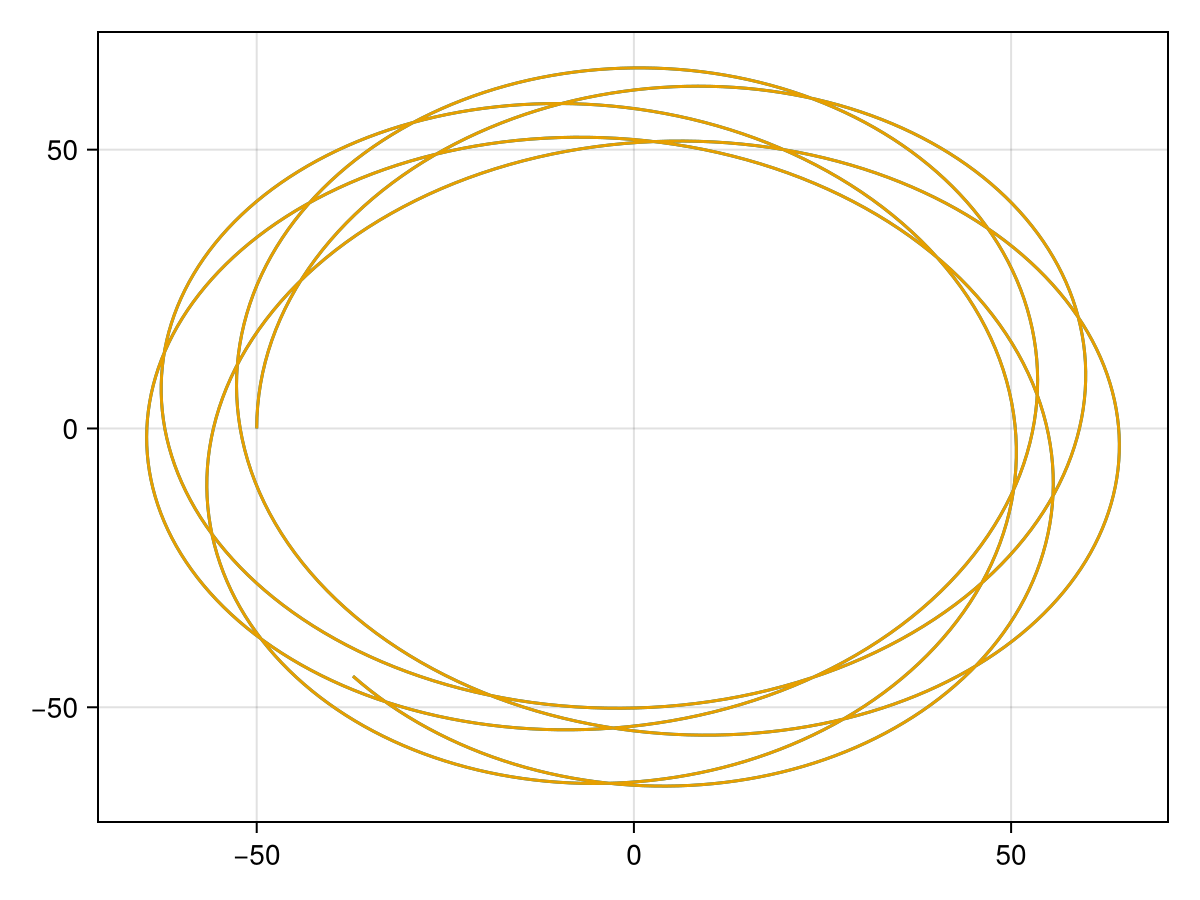

In [42]:
sol_gala = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=t₂*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    Integrator_kwargs=Dict("rtol"=>5.0e-12, "atol"=>0.5e-12))
sol = evolve(pot, x₀, v₀, t_range, DP5(); options=ntSolverOptions(;reltol=5.0e-12, abstol=0.5e-12, saveat=Δt))
@show 𝕤.ode
@show sol_gala.t[-1]
@show sol.t[end]
orb_gala_x = pyconvert(Vector{Float64}, sol_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, sol_gala.y)
orb_x = sol.x[1,:]
orb_y = sol.x[2,:]
sol_diff = abs.(orb_gala_x-orb_x)
@show findmax(sol_diff)
lines(orb_gala_x,orb_gala_y)
lines!(orb_x,orb_y)
current_figure()



In [51]:
@btime pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    Integrator_kwargs=Dict("rtol"=>5.0e-8))


  2.509 ms (89 allocations: 2.27 KiB)


Python: <Orbit cartesian, dim=3, shape=(1001,)>

In [54]:
@btime evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-8, saveat=Δt))

  3.992 ms (77687 allocations: 3.05 MiB)


Orbit{Float64, Float64, Float64}
  t: Array{Float64}((1001,)) [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99, 10.0]
  x: Array{Float64}((3, 1001)) [-50.0 -49.968408649039 … -36.09573454676481 -37.23745911797275; -0.0 1.99957878361291 … -45.74610789085238 -44.4230952359397; -0.0 0.0 … 0.0 0.0]
  v: Array{Float64}((3, 1001)) [0.0 6.3172417351097385 … -115.85538001135994 -112.46569141865722; 200.0 199.8736491210558 … 130.21110108287098 134.37876881716934; 0.0 0.0 … 0.0 0.0]
